In [ ]:
# =============================================================================
# SECCIÓN 1: INSTALACIÓN DE DEPENDENCIAS CON UV
# =============================================================================
import shutil

# Instalamos 'uv' en el sistema si no existe
if shutil.which("uv") is None:
    !pip install uv -q

# Utilizamos uv para instalar las librerías del proyecto de forma ultra rápida
!uv pip install --system pandas numpy torch pygad scikit-learn matplotlib seaborn

Using Python 3.12.12 environment at: /usr
Resolved 47 packages in 600ms
Prepared 1 package in 13ms
Installed 1 package in 5ms
 + pygad==3.5.0


In [ ]:
# =============================================================================
# SECCIÓN 2: DESCARGA Y RE-ENSAMBLAJE DE DATOS (REMOTE ➔ LOCAL)
# =============================================================================

import torch
import os
import requests

# 1. Configuración de Rutas y URLs
BASE_RAW_URL = "https://raw.githubusercontent.com/berniehans/ProjectEvo-Callao-Safety/main/data_processed/"
LOCAL_DIR = "data_processed/"
os.makedirs(LOCAL_DIR, exist_ok=True)

def download_file(filename):
    url = BASE_RAW_URL + filename
    local_path = os.path.join(LOCAL_DIR, filename)

    print(f"📥 Descargando {filename}...", end=" ")
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        print("✅ Hecho")
    else:
        print(f"❌ Error {response.status_code}")

# 2. Descargar Meta-datos
download_file("metadata.pt")

# 3. Cargar Meta-datos con weights_only=False para permitir objetos Numpy
# Esto soluciona el UnpicklingError
meta = torch.load(os.path.join(LOCAL_DIR, 'metadata.pt'), weights_only=False)
num_chunks = meta['total_chunks']
class_names = meta['class_names']
print(f"📦 Detectados {num_chunks} fragmentos en el repositorio.")

# 4. Descargar fragmentos
for i in range(1, num_chunks + 1):
    part_name = f"bert_embeddings_part_{i}.pt"
    if not os.path.exists(os.path.join(LOCAL_DIR, part_name)):
        download_file(part_name)

# 5. Re-ensamblaje
all_embeddings = []
all_labels = []

print(f"\n📂 Re-ensamblando tensores...")
for i in range(1, num_chunks + 1):
    # También aplicamos weights_only=False aquí por consistencia
    chunk = torch.load(os.path.join(LOCAL_DIR, f'bert_embeddings_part_{i}.pt'), weights_only=False)
    all_embeddings.append(chunk['embeddings'])
    all_labels.append(chunk['labels'])

X = torch.cat(all_embeddings, dim=0).numpy()
y = torch.cat(all_labels, dim=0).numpy()

print("="*50)
print(f"✅ RE-ENSAMBLAJE COMPLETADO: {X.shape[0]} registros listos.")
print("="*50)

📥 Descargando metadata.pt... ✅ Hecho
📦 Detectados 4 fragmentos en el repositorio.
📥 Descargando bert_embeddings_part_1.pt... ✅ Hecho
📥 Descargando bert_embeddings_part_2.pt... ✅ Hecho
📥 Descargando bert_embeddings_part_3.pt... ✅ Hecho
📥 Descargando bert_embeddings_part_4.pt... ✅ Hecho

📂 Re-ensamblando tensores...
✅ RE-ENSAMBLAJE COMPLETADO: 98458 registros listos.


In [ ]:
# =============================================================================
# SECCIÓN 3: PREPARACIÓN DE TENSORES EN GPU
# =============================================================================

import torch

# Verificamos dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Usando dispositivo: {torch.cuda.get_device_name(0)}")

# Convertimos los datos re-ensamblados a Tensores de PyTorch y los subimos a la GPU
# Usamos float16 para mayor velocidad
X_gpu = torch.tensor(X).to(device).half()
y_gpu = torch.tensor(y).to(device).long()

# Split manual en GPU
train_size = int(0.7 * len(X_gpu))
X_train_gpu, X_val_gpu = X_gpu[:train_size], X_gpu[train_size:]
y_train_gpu, y_val_gpu = y_gpu[:train_size], y_gpu[train_size:]

print(f"✅ Datos cargados en VRAM. Memoria libre: {torch.cuda.mem_get_info()[0]/1e9:.2f} GB")

🚀 Usando dispositivo: Tesla T4
✅ Datos cargados en VRAM. Memoria libre: 15.24 GB


In [ ]:
# =============================================================================
# SECCIÓN 4: FITNESS FUNCTION "HIGH-INTENSITY"
# =============================================================================

from sklearn.metrics import f1_score

def fitness_func(ga_instance, solution, solution_idx):
    mask = torch.tensor(solution, device=device).bool()
    X_train_sub = X_train_gpu[:, mask]
    X_val_sub = X_val_gpu[:, mask]

    input_dim = X_train_sub.shape[1]
    if input_dim == 0: return 0

    # Modelo MLP
    model = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, len(class_names))
    ).to(device).half()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        outputs = model(X_train_sub)
        loss = criterion(outputs, y_train_gpu)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_sub)
        val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()

    f1 = f1_score(y_val_gpu.cpu().numpy(), val_preds, average='macro')

    # Penalización de parsimonia más agresiva (queremos calidad, no cantidad)
    # Si logras el mismo F1 con menos dimensiones, el fitness será mayor.
    penalty = 0.005 * (mask.sum().item() / 768)

    return float(f1 - penalty)

In [ ]:
# =============================================================================
# SECCIÓN 5: CONFIGURACIÓN AGRESIVA DEL GA
# =============================================================================

from tqdm.auto import tqdm
import pygad
import numpy as np

# 1. Parámetros de la evolución
n_gen = 150
sol_per_pop = 100

# 2. Inicialización de la barra de progreso
# Usamos leave=True para que la barra se quede al finalizar en el notebook
pbar = tqdm(total=n_gen, desc="🧬 Optimizando Características", leave=True)

def on_generation(ga_instance):
    # Actualizar la barra de progreso
    pbar.update(1)

    # EXTRAER EL MEJOR FITNESS DE FORMA SEGURA:
    # PyGAD guarda los fitness de la última generación en 'last_generation_fitness'
    if ga_instance.last_generation_fitness is not None:
        best_f1_current = np.max(ga_instance.last_generation_fitness)
        pbar.set_postfix({"Best F1": f"{best_f1_current:.4f}"})

# 3. Configuración del GA optimizada para estabilidad
ga_instance = pygad.GA(
    num_generations=n_gen,
    sol_per_pop=sol_per_pop,
    num_parents_mating=40,
    fitness_func=fitness_func,
    num_genes=768,
    gene_space=[0, 1],
    parent_selection_type="tournament",
    K_tournament=5,
    crossover_type="two_points",
    mutation_type="adaptive",
    mutation_percent_genes=[3, 1],
    on_generation=on_generation,
    save_best_solutions=False,
    keep_elitism=2,
    stop_criteria=["reach_0.98", "saturate_20"]
)

# 4. Ejecución protegida
print(f"🔥 Iniciando búsqueda intensiva")
try:
    ga_instance.run()
except Exception as e:
    print(f"⚠️ Se produjo un error durante la ejecución: {e}")
finally:
    pbar.close()

print("\n✅ Proceso completado exitosamente.")

🧬 Optimizando Características:   0%|          | 0/150 [00:00<?, ?it/s]

🔥 Iniciando búsqueda intensiva

✅ Proceso completado exitosamente.


/usr/local/lib/python3.12/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


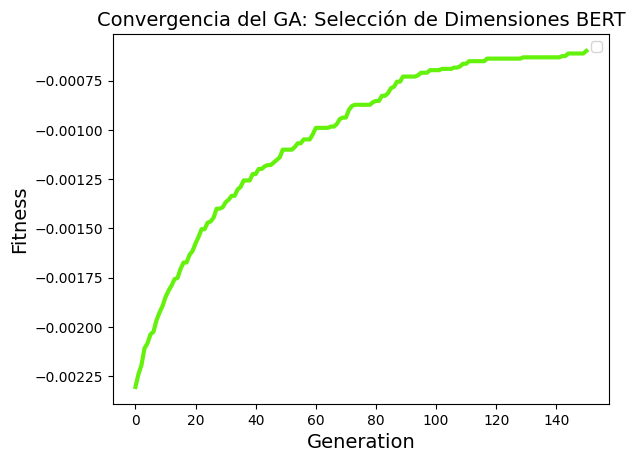


🏆 MEJOR SOLUCIÓN ENCONTRADA:
- Fitness (F1 optimizado): -0.0006
- Características seleccionadas: 92 de 768
- Reducción de dimensionalidad: 88.02%


In [ ]:
# =============================================================================
# SECCIÓN 6: RESULTADOS Y CURVA DE CONVERGENCIA
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Graficar Convergencia
ga_instance.plot_fitness(title="Convergencia del GA: Selección de Dimensiones BERT")

solution, solution_fitness, solution_idx = ga_instance.best_solution()
features_seleccionadas = np.sum(solution)

print(f"\n🏆 MEJOR SOLUCIÓN ENCONTRADA:")
print(f"- Fitness (F1 optimizado): {solution_fitness:.4f}")
print(f"- Características seleccionadas: {int(features_seleccionadas)} de 768")
print(f"- Reducción de dimensionalidad: {((1 - features_seleccionadas/768)*100):.2f}%")

In [ ]:
# =============================================================================
# SECCIÓN 7: GUARDADO DE LA MÁSCARA ÓPTIMA
# =============================================================================

import os

os.makedirs('models', exist_ok=True)
mask_data = {
    'best_mask': solution,
    'f1_score': solution_fitness,
    'features_count': features_seleccionadas
}

torch.save(mask_data, 'models/ga_feature_mask.pt')
print("💾 Máscara evolucionada guardada en 'models/ga_feature_mask.pt'")

💾 Máscara evolucionada guardada en 'models/ga_feature_mask.pt'
